In [1]:
%matplotlib notebook

import json_lines
from collections import defaultdict

import jieba
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import datetime
import numpy as np
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

font = font_manager.FontProperties(fname='msjh.ttc', size=14)
sns.set(style='whitegrid')

In [2]:
# load ptt posts

path = 'output\Gossiping-2000.json'
target_day = datetime.date(2017, 6, 4)

# with open(path, 'rb') as f:
#     for post in json_lines.reader(f):
#         print(post['title'])

# Title Analysis

In [3]:
# get title

total_title = defaultdict(int)

with open(path, 'rb') as f:
    total_post_number = 0
    for post in json_lines.reader(f):
        post_date_str = post['date']
        post_date = datetime.datetime.strptime(post_date_str, '%Y-%m-%d %H:%M:%S')
         
        if (post_date.date() == target_day):
            title = post['title']
            total_title[title] += 1
            total_post_number = total_post_number + 1
    print(total_post_number)

2593


In [4]:
def show_distributions(counts):
    sorted_cnts = [t[0] for t in sorted(counts.items(), key=lambda x: -x[1])][:10]
    y = [counts[u] for u in sorted_cnts]

    x = range(len(y))
    top_names = [x for x in sorted_cnts]
    
#     f, ax = plt.subplots(figsize=(10, 10))
    
#     sns.set_color_codes('pastel')
#     sns.plt.plot(x, y, label='Total {}'.format('comments'), color='blue')
    
#     ax.legend(ncol=3, loc='upper right', frameon=True)
#     ax.set(ylabel='counts',
#            xlabel='',
#            title='Total comments')
#     ax.set_xticklabels(top_names, rotation=90, fontproperties=font)
#     sns.despine(left=True, bottom=True)

#     plt.show(f)
    
    for user in top_names:
        print(user)
    for i in y:
        print(i)

In [5]:
# display pushes
show_distributions(total_title)

Re: [問卦] 我中國室友堅稱六四沒死半個人的八卦
Re: [問卦] 為什麼恐怖分子都不會在中國犯案?
Re: [新聞] 談治水 柯P：這國家很奇怪 喜歡花錢做效
Re: [新聞] 李開復：台灣服務業是AI無法取代
Re: [問卦] 我的中國同學對於恐攻與民主的看法
Re: [問卦] 有反核人士認為火力發電很乾淨的卦？
Re: [新聞] 1.98分 虎師當掉8成生
Re: [新聞] 王丹：台灣越勇 中國越不敢打
Re: [問卦] 基隆真的存在嗎？
Re: [新聞] 發電結構改變 電價漲定了
15
13
13
12
12
12
11
7
7
7


# Word Analysis

In [6]:
# grap post
words = []
scores = []
jieba.set_dictionary('dict.txt.big')
with open(path, 'rb') as f:
    for post in json_lines.reader(f):
        post_date_str = post['date']
        post_date = datetime.datetime.strptime(post_date_str, '%Y-%m-%d %H:%M:%S')
         
        if (post_date.date() == target_day):
#             print (post_date)
            d = defaultdict(int)

            content = post['content']
            if post['score'] != 0:
                for l in content.split('\n'):
                    if l:
                        for w in jieba.cut(l):
                            d[w] += 1
                if len(d) > 0:
                    words.append(d)
                    scores.append(1 if post['score'] > 0 else 0)

Building prefix dict from C:\Users\蔡奇宏\Desktop\scrapy\dict.txt.big ...
Loading model from cache C:\Users\蔡奇宏\AppData\Local\Temp\jieba.u448f780059d72ef892e16ade52b4cd8a.cache
Loading model cost 1.469 seconds.
Prefix dict has been built succesfully.


In [7]:
# grap comments
c_words = []
c_scores = []

with open(path, 'rb') as f:
    for post in json_lines.reader(f):
        
        post_date_str = post['date']
        post_date = datetime.datetime.strptime(post_date_str, '%Y-%m-%d %H:%M:%S')
        
        if (post_date.date() == target_day):
            for comment in post['comments']:
                l = comment['content'].strip()
                if l and comment['score'] != 0:
                    d = defaultdict(int)
                    for w in jieba.cut(l):
                        d[w] += 1
                    if len(d) > 0:
                        c_scores.append(1 if comment['score'] > 0 else 0)
                        c_words.append(d)

In [8]:
# convert to vectors
dvec = DictVectorizer()
tfidf = TfidfTransformer()
X = tfidf.fit_transform(dvec.fit_transform(words))

c_dvec = DictVectorizer()
c_tfidf = TfidfTransformer()
c_X = c_tfidf.fit_transform(c_dvec.fit_transform(c_words))

In [9]:
svc = LinearSVC()
svc.fit(X, scores)

c_svc = LinearSVC()
c_svc.fit(c_X, c_scores)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [10]:
def display_top_features(weights, names, top_n, select=abs):
    
    
    top_features = sorted(zip(weights, names), key=lambda x: select(x[0]), reverse=True)[:top_n]
    top_weights = [x[0] for x in top_features]
    top_names = [x[1] for x in top_features]

    fig, ax = plt.subplots(figsize=(10,8))
    ind = np.arange(top_n)
    bars = ax.bar(ind, top_weights, color='blue', edgecolor='black')
    for bar, w in zip(bars, top_weights):
        if w < 0:
            bar.set_facecolor('red')
   
    width = 0.30
    ax.set_xticks(ind + width)
    ax.set_xticklabels(top_names, rotation=90, fontproperties=font)

    plt.show(fig)
    
    for word in top_names:
        print (word)

<IPython.core.display.Javascript object>


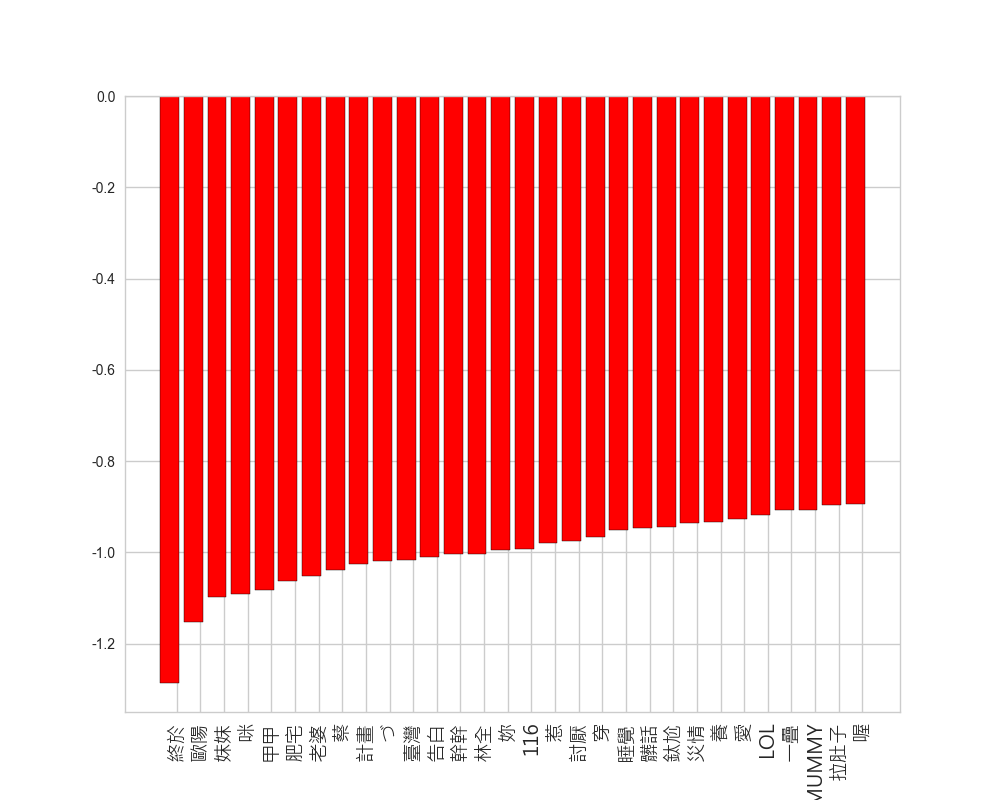

終於
歐陽
妹妹
咪
甲甲
肥宅
老婆
蔡
計畫
づ
臺灣
告白
幹幹
林全
妳
116
惹
討厭
穿
睡覺
髒話
鈦尬
災情
養
愛
LOL
一疊
MUMMY
拉肚子
喔


In [11]:
# top features for posts
display_top_features(svc.coef_[0], dvec.get_feature_names(), 30)

<IPython.core.display.Javascript object>


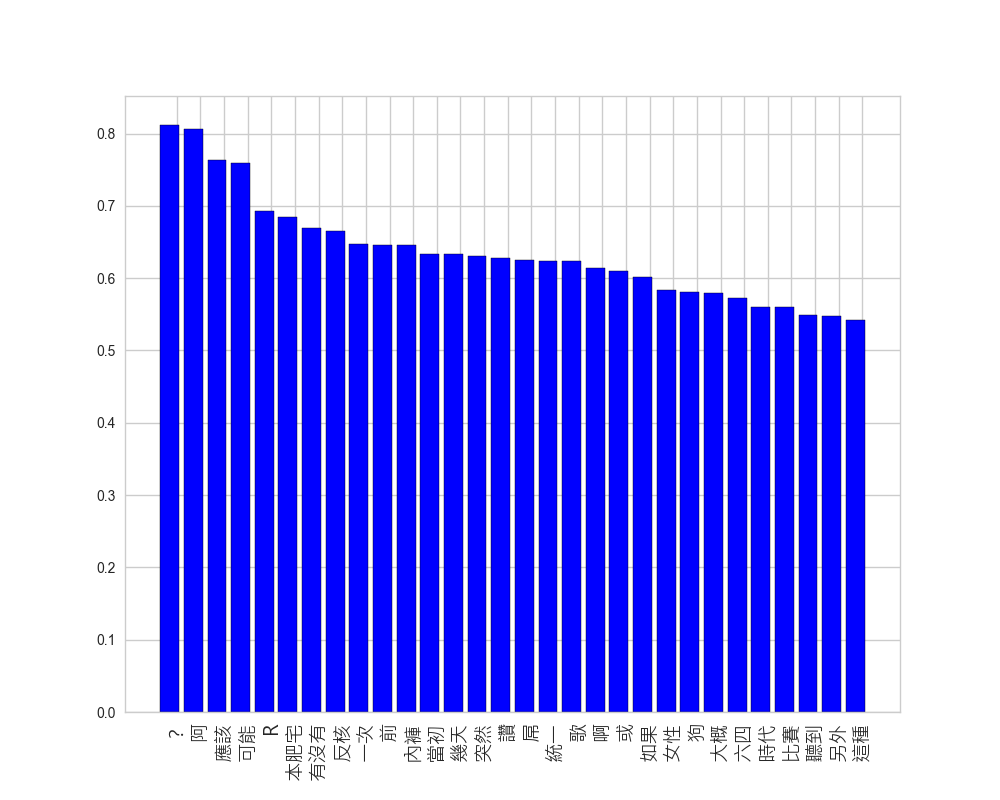

？
阿
應該
可能
R
本肥宅
有沒有
反核
一次
前
內褲
當初
幾天
突然
讚
屌
統一
歌
啊
或
如果
女性
狗
大概
六四
時代
比賽
聽到
另外
這種


In [12]:
# top positive features for posts
display_top_features(svc.coef_[0], dvec.get_feature_names(), 30, select=lambda x: x)

<IPython.core.display.Javascript object>


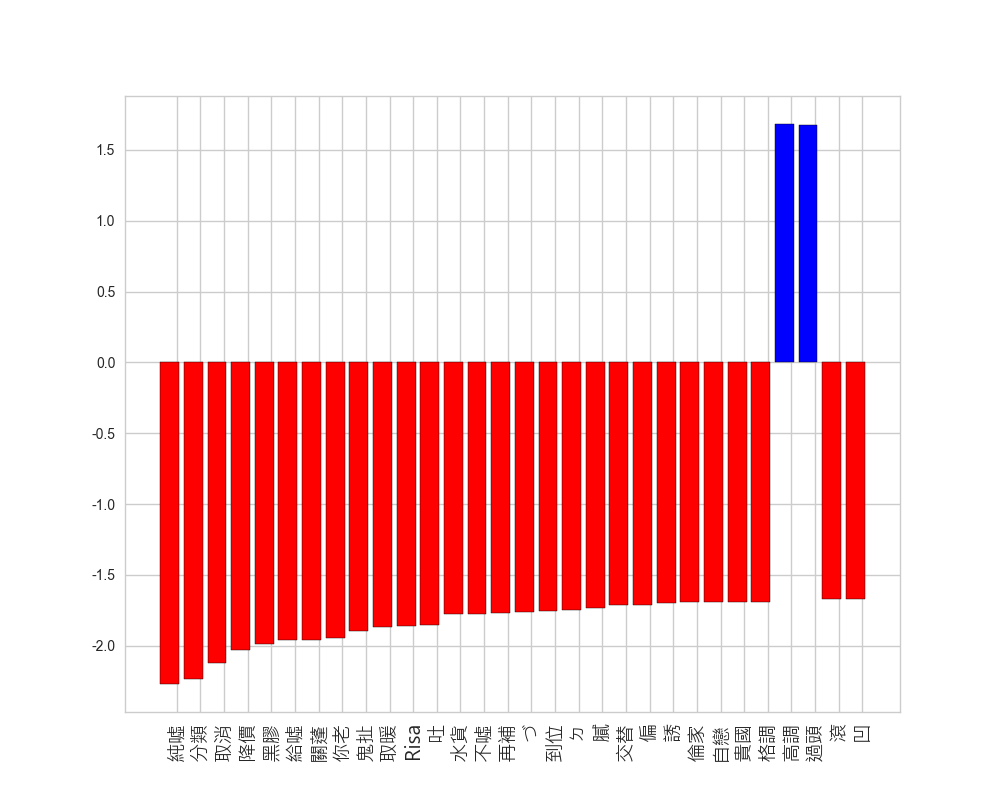

純噓
分類
取消
降價
黑膠
給噓
關蓬
你老
鬼扯
取暖
Risa
吐
水貨
不噓
再補
づ
到位
ㄉ
膩
交替
偏
誘
倫家
自戀
貴國
格調
高調
過頭
滾
凹


In [13]:
# top features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30)

<IPython.core.display.Javascript object>


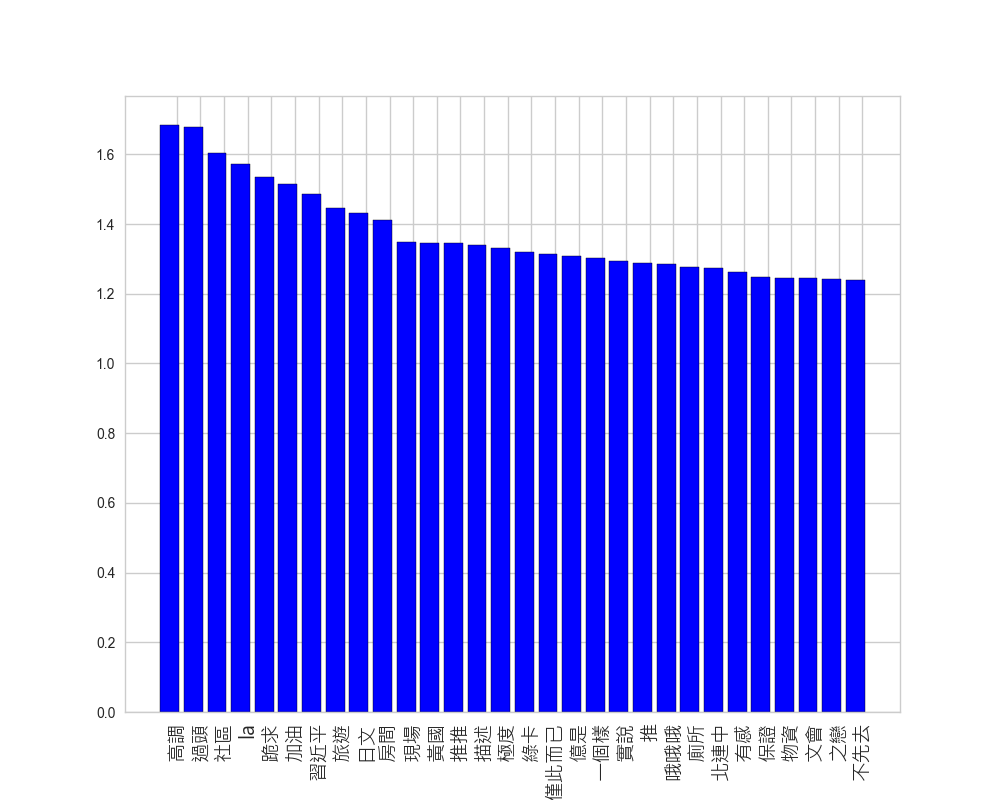

高調
過頭
社區
la
跪求
加油
習近平
旅遊
日文
房間
現場
黃國
推推
描述
極度
綠卡
僅此而已
億是
一個樣
實說
推
哦哦哦
廁所
北連中
有感
保證
物資
文會
之戀
不先去


In [14]:
# top positive features for comments
display_top_features(c_svc.coef_[0], c_dvec.get_feature_names(), 30, select=lambda x: x)